In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
        
from sklearn import metrics


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
dataset = pd.read_csv('/kaggle/input/faces-age-detection-dataset/train.csv')

In [5]:
dataset.head(10)

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE
5,6283.jpg,MIDDLE
6,23495.jpg,YOUNG
7,7100.jpg,YOUNG
8,6028.jpg,YOUNG
9,22617.jpg,OLD


In [6]:
dataset['Class'].unique()

array(['MIDDLE', 'YOUNG', 'OLD'], dtype=object)

<AxesSubplot:>

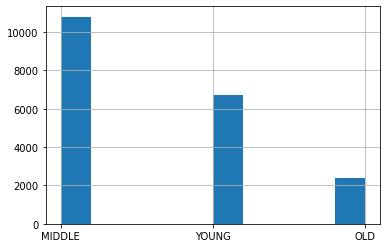

In [7]:
dataset['Class'].hist()

In [8]:
dataset['Class'].replace(['YOUNG', 'MIDDLE','OLD'], [0, 1, 2], inplace=True)

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import TensorBoard
from sklearn.metrics import classification_report,confusion_matrix
import itertools

In [10]:
# Methods for loading images.
def imageReader(path,ch = 3, resize=(64,64)):
    kp = tf.io.read_file(path)
    kp = tf.image.decode_jpeg(kp, channels=ch)
    kp = tf.image.convert_image_dtype(kp, dtype=tf.float32)
    kp = tf.image.resize(kp, resize)
    return kp

def load_data(image_path, label):
    image = imageReader(image_path, 3, (64,64))
    
    return (image, label)

In [11]:
import glob
# Initializing image paths variables.
image_paths = glob.glob('/kaggle/input/faces-age-detection-dataset/Train/*.jpg')
print(len(image_paths))

19906


In [12]:
# Initialize label values
label_list = []
for i in image_paths:
    _,tail = os.path.split(i)
    label = dataset.loc[dataset['ID'] == tail]['Class'].values[0]
    label_list.append(label)
# print(len(label_list))

In [14]:
import tensorflow as tf

# Create Train, Test, and Validation datasets
train_size = int(0.8*(len(image_paths)))
test_size = 20

train_dataset = tf.data.Dataset.from_tensor_slices((image_paths[:train_size], label_list[:train_size]))
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths[train_size:train_size + test_size], label_list[train_size :train_size + test_size]))
validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths[train_size + test_size:], label_list[train_size + test_size:]))

In [15]:
# Creating Autotune objects
# For Autotune objects the prefetch buffer sizes are automitically tuned. 
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = (train_dataset
    .map(load_data, num_parallel_calls=AUTOTUNE)
    .batch(64)
    .prefetch(AUTOTUNE)
)


In [16]:
# Adding data agumentation to training images.
# Data agumentation adds variation to training data
train_dataset = train_dataset.map(
    lambda image, label: (tf.image.random_flip_left_right(image), label)
).cache(
).map(
    lambda image, label: (tf.image.per_image_standardization(image), label)
).map(
    lambda image, label: (tf.image.random_contrast(image, lower=0.4, upper=0.6), label)
).map(
    lambda image, label: (tf.image.random_brightness(image, max_delta = 0.4), label)
).map(
    lambda image, label: (tf.image.random_hue(image, max_delta = 0.4), label)
).map(
    lambda image, label: (tf.image.random_saturation(image, lower=0.4, upper=0.6), label)
).shuffle(
    1000
).repeat(2)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
validation_dataset = (validation_dataset
    .map(load_data, num_parallel_calls=AUTOTUNE)
    .batch(64)
    .prefetch(AUTOTUNE)
)

In [18]:
# Adding data agumentation to validation images.
validation_dataset = validation_dataset.map(
    lambda image, label: (tf.image.random_flip_left_right(image), label)
).cache(
).map(
    lambda image, label: (tf.image.per_image_standardization(image), label)
).map(
    lambda image, label: (tf.image.random_contrast(image, lower=0.4, upper=0.6), label)
).map(
    lambda image, label: (tf.image.random_brightness(image, max_delta = 0.4), label)
).map(
    lambda image, label: (tf.image.random_hue(image, max_delta = 0.4), label)
).map(
    lambda image, label: (tf.image.random_saturation(image, lower=0.4, upper=0.6), label)
).shuffle(
    1000
).repeat(2)

In [19]:
test_dataset = (test_dataset
    .map(load_data, num_parallel_calls=AUTOTUNE)
    .batch(64)
    .prefetch(AUTOTUNE)
)

In [20]:
# Standardizing the test data.
test_dataset = test_dataset.map(
    lambda image, label: (tf.image.per_image_standardization(image), label)
)

In [21]:
# Using VGG 16
preprocess_input = tf.keras.applications.vgg16.preprocess_input
model = tf.keras.applications.VGG16(input_shape = (64,64,3,),include_top=False,weights='imagenet')


58900480/58889256 [==============================] - 0s 0us/step


In [36]:
# Set model.trainable to false, this prevents changing weights of pre-trained model.
model.trainable = False

# Adding custom layers to the pre-trained model.
inputs = tf.keras.Input(shape=(64, 64, 3))
x = preprocess_input(inputs)
x = model(x, training=True)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1000)(x)
x = tf.keras.layers.Dense(600)(x)
x = tf.keras.layers.Dense(600)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(400)(x)
x = tf.keras.layers.Dense(400)(x)
x = tf.keras.layers.Dense(100)(x)
x = tf.keras.layers.Dense(100)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(50)(x)
x = tf.keras.layers.Dense(50)(x)
x = tf.keras.layers.Dense(20)(x)
x = tf.keras.layers.Dense(20)(x)
outputs = tf.keras.layers.Dense(3)(x)
model = tf.keras.Model(inputs, outputs)

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [37]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_6 ( (None, 64, 64, 3)         0         
_________________________________________________________________
tf.nn.bias_add_6 (TFOpLambda (None, 64, 64, 3)         0         
_________________________________________________________________
model_4 (Functional)         (None, 3)                 23352133  
_________________________________________________________________
flatten_5 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_55 (Dense)             (None, 1000)              4000      
_________________________________________________________________
dense_56 (Dense)             (None, 600)               6006

In [39]:
history = model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20
498/498 [==============================] - 22s 35ms/step - loss: 0.9555 - sparse_categorical_crossentropy: 0.9555 - val_loss: 0.9699 - val_sparse_categorical_crossentropy: 0.9698
Epoch 2/20
498/498 [==============================] - 21s 34ms/step - loss: 0.9532 - sparse_categorical_crossentropy: 0.9532 - val_loss: 0.9587 - val_sparse_categorical_crossentropy: 0.9586
Epoch 3/20
498/498 [==============================] - 22s 34ms/step - loss: 0.9528 - sparse_categorical_crossentropy: 0.9528 - val_loss: 0.9634 - val_sparse_categorical_crossentropy: 0.9633
Epoch 4/20
498/498 [==============================] - 22s 34ms/step - loss: 0.9526 - sparse_categorical_crossentropy: 0.9525 - val_loss: 0.9590 - val_sparse_categorical_crossentropy: 0.9589
Epoch 5/20
498/498 [==============================] - 22s 34ms/step - loss: 0.9524 - sparse_categorical_crossentropy: 0.9524 - val_loss: 0.9588 - val_sparse_categorical_crossentropy: 0.9587
Epoch 6/20
498/498 [==============================

In [46]:
print("accuracy:   %0.3f" % metrics.accuracy_score(actual_values, predictions))

accuracy:   0.400
